## Installing Packages

In [527]:
!pip install pandas sqlite3 geopy matplotlib basemap numpy scipy pyproj

ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing Libraries

- **pandas** - Used for data loading, data manipulation and storing in `DataFrame`'s
- **sqlite3** - Library for leveraging SQL databases, used here due to its simlicity and efficiency in handling small amounts of data
- **geopy** - Used for distance between points calculation with usage of `geodesic()` method
- **matplotlib** - Leveraged for plotting purposes
- **mpl_toolkits.basemap** - Utilized for more complex map visualization (in this case showing Mercator map with points)
- **csv** - Used for applying specific value to quoting parameter to `pandas.read_csv()` to prevent from incorrect data reading due to multiple quotes in columns """
- **numpy** - Enables faster numerical operations
- **scipy.spatial** - Gives us opportunity to use `ConvexHull` for computing the convex hull of a set of points which is the smallest convex polygon that contains all provided points
- **pyproj** - Used for projecting coordinates

In [528]:
import csv
import sqlite3
import pyproj
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.distance import geodesic
from scipy.spatial import ConvexHull

## Data Loading

Here we are using pandas `.read_csv()` method for reading data from csv file and storing it in pandas `DataFrame` which similar to SQL format. We are using also `csv` library to add a parameter to `.read_csv()` method to ignore quoting, since it could generate errors in proper column reading.

In [529]:
# Reading csv file and loading into DataFrame
data = pd.read_csv('points.csv', quoting=csv.QUOTE_NONE)

# Let's see the loaded data
data.head()

,name,latitude,longitude,height,date_added,metadata
0,Moscow,"""55.7558°""","""37.6173°""",0.200,"""2024-05-14 12:34""","""country=Russia;population=12.5M;language=Russ..."
1,Ottawa,"""45° 25.29'""","""-75° 41.832' W""",0.070,"""2024-05-20 08:15""","""country=Canada;population=1M;language=English..."
2,Beijing,"""39° 54' 15""""","""116° 24' 26"" E""",0.044,"""2024-05-22 17:45""","""country=China;population=21.5M;language=Manda..."
3,Washington D.C.,"""38° 54' 25.92"" N""","""-77° 2' 12.84"" W""",0.025,"""2024-05-18 06:30""","""country=United States;population=705K;languag..."
4,Brasilia,"""-15.7942°""","""-47.8822°""",1.172,"""2024-05-19 20:00""","""country=Brazil;population=3M;language=Portugu..."


## Useful functions
- Removing quotes
- Converting coordinates
- Projecting coordinates
- Getting vertices of a figure which contains all points
- Calculating perimeter
- Visualizing points on map
- Visualizing figure containing points on map

In [530]:
# Quote removing function
def remove_quotes(value: str) -> str:
	"""
	Function which removes quotes at the beginning and at the end.

	Args:
			value (str): Value from the column which contains quotes.
			
	Returns:
			(str): Value with quotes removed.
	"""

	# Checking whether value is surrounded by quotes ("")
	if value[0] == '"' and value[-1] == '"':
		return value[1:-1]
	return value

In [531]:
# Converting coordinate function
def convert_coordinate(coord: str) -> float:
    """
    Function that converts various geographical coordinate formats to decimal degrees.
    
    Args:
        coord (str): Coordinate presented in different formats:
            1. Degrees with decimal (e.g., "34.1234°")
            2. Degrees and minutes with decimal (e.g., "34° 12.345'")
            3. Degrees, minutes, and seconds (e.g., "34° 12' 34"")
            4. Includes direction letters (N, E, S, W) (e.g., "34° 5' 15.22" W")
    
    Returns:
        converted_coord (float): Converted coordinate in decimal degrees format (1).
    """

    # Handling the case with NESW directions
    reverse = False
    if 'S' in coord or 'W' in coord:
        reverse = True

    for char in 'NESW':
        coord = coord.replace(char, "")
    
    # Initialize components
    degrees = 0
    minutes = 0
    seconds = 0
    
    # Extracting degrees
    if '°' in coord:
        degrees = float(coord[: coord.index('°')])
    # Extracting minutes
    if "'" in coord:
        minutes = float(coord[coord.index("°") + 1 : coord.index("'")])
    # Extracting seconds
    if '"' in coord:
        seconds = float(coord[coord.index("'") + 1 : coord.index('"')])
        
    # Calcualting result
    minutes += seconds / 60
    if degrees < 0:
        converted_coord = degrees - minutes / 60
    else:
        converted_coord = degrees + minutes / 60
    
    # Handling the case with NESW directions
    if reverse and degrees > 0:
        converted_coord *= -1

    # Rounding to clean numbers with long decimal expansion (e.g. 23.666666666)
    converted_coord = round(converted_coord, 4)

    # Returning result
    return converted_coord

In [532]:
# Projecting coordinates function
def project_coordinates(latitude: float, longitude: float) -> tuple[float, float]:
    """ 
    Projecting latitude and longitude into flat map using Mercator projection and converting output to kilometers.

    Args:
        latitude (float): Point's latitude
        longitude (float): Point's longitude
    Returns:
        (x, y) (tuple[float, float]): Coordinates in kilometers.
    """

    # Initializing projection object
    projection = pyproj.Proj(proj='merc', ellps='WGS84')

    # Using projection object for projection
    x, y = projection(longitude, latitude)

    # Returning coordinates
    return x / 1000.0, y / 1000.0

In [533]:
# Extracting vertices function
def get_vertices(points: list[tuple[float, float]]) -> list[int]:
    """
    Function responsible for calculating vertices of a figure which contains all the points provided.

    Args:
        points (list[tuple[float, float]]): List of points which contains latitude, longitude.
    Returns:
        vertices (list[int]): List of indexes of points which are vertices of a figure.
    """

    # Computing projected points
    projected_points = [project_coordinates(latitude, longitude) for latitude, longitude in points]

    # Calculating vertices of convex hull
    hull = ConvexHull(projected_points)
    vertices = hull.vertices

    # Ensuring the vertices list is closed by appending the start vertex at the end since we have to perform the last distance compution using the first point
    vertices = np.append(vertices, vertices[0])

    # Returning result
    return vertices

In [534]:
# Perimeter calculating function
def calculate_perimeter(points: list[tuple[float, float, float]]) -> float:
    """
    Calculating the perimeter of the convex hull of given geographic points.

    Args:
        points (list[tuple[float, float]]): List of tuples containing latitude, longitude.

    Returns:
        perimeter (float): Perimeter in kilometers.
    """

    # Computing the convex hull
    vertices = get_vertices(points)

    # Calculating perimeter using the vertices of the convex hull
    perimeter = 0.0
    for i in range(len(vertices) - 1):
        current_index, next_index = vertices[i], vertices[i + 1]
        current_point, next_point = points[current_index], points[next_index]

        # Calculating distance
        # Here we are not including height, since it does not have much influence on the distance. The distance also is not a straight line due to Earth surface.
        distance = geodesic((current_point[0], current_point[1]), (next_point[0], next_point[1])).kilometers
        
        perimeter += distance

    return perimeter

In [535]:
# Point visualizing function
def visualize_points(points: list[tuple[str, float, float]]) -> None:
    """
    Function that plots geographical points on a Mercator map using Basemap.

    Args:
        points (list[tuple[str, float, float]]): List of (name, latitude, longitude) tuples.
    Returns:
        None
    """

    # Creating a figure and axis
    plt.figure(figsize=(16, 10))
    
    # Creating a Mercator map specifying projection='merc' using Basemap
    map = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')
    
    # Drawing coastlines and country boundaries
    map.drawcoastlines(color='gray')
    map.drawcountries(color='gray')
    
    # Drawing latitude and longitude lines
    map.drawparallels(range(-90, 91, 10), labels=[1, 0, 0, 0], color='gray')
    map.drawmeridians(range(-180, 181, 20), labels=[0, 0, 0, 1], color='gray')
    
    # Looping through each point and plotting it
    for name, latitude, longitude in points:
        # Converting longitude and latitude to x and y coordinates for the map
        x, y = map(longitude, latitude)
        
        # Plotting point using matplotlib's scatter plot
        map.scatter(x, y, marker='o', color='magenta', zorder=5)
        
        # Labeling the point with its coordinates and height
        label = f"{name}, {latitude}°, {longitude}°"
        plt.text(x, y, label, color='white', fontsize=12, ha='left', va='bottom')
    
    # Setting map to be more realistic
    map.bluemarble()

    # Showing the plot
    plt.title('Map Visualization with Points with Details')
    plt.show()

In [536]:
# Figure visualizing function
def visualize_figure(points: list[tuple[float, float]]) -> None:
		"""
		Function which purpose is to visualize a figure that contains all points provided.

		Args:
				points (list[tuple[float, float]]): List of points in which each point is a tuple of latitude and longitude.
		Returns:
				None
		"""

		# Getting figure vertices
		vertices = get_vertices(points)

		# Creating a figure and axis
		plt.figure(figsize=(16, 10))
		
		# Creating a Mercator map specifying projection='merc' using Basemap
		map = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')
		
		# Drawing coastlines and country boundaries
		map.drawcoastlines(color='gray')
		map.drawcountries(color='gray')

		# Plotting all points
		for latitude, longitude in points:
				x, y = map(longitude, latitude)
				map.scatter(x, y, color='magenta', zorder=5)

		# Initializing figure vertices coordinates lists
		figure_xs = []
		figure_ys = []
		
		# Plotting borders of a figure
		for vertice_index in vertices:
				x, y = map(points[vertice_index][1], points[vertice_index][0])
				figure_xs.append(x)
				figure_ys.append(y)
		map.plot(figure_xs, figure_ys, marker=None, color='blue', linewidth=2, zorder=4)
		
		# Showing map
		plt.title('Map Visualization of a Figure Containing Provided Points')
		plt.show()

## Data Cleaning and Normalization

- Removing unnecessary quotes in columns.
- Converting latitude and longitude to the same single format (degrees with decimal points).

In [537]:
# Removing quotes
for column in ['latitude', 'longitude', 'date_added', 'metadata']:
	data[column] = data[column].apply(remove_quotes)

# Checking if operations were successful
data.head()

,name,latitude,longitude,height,date_added,metadata
0,Moscow,55.7558°,37.6173°,0.200,2024-05-14 12:34,country=Russia;population=12.5M;language=Russian
1,Ottawa,45° 25.29',-75° 41.832' W,0.070,2024-05-20 08:15,country=Canada;population=1M;language=English/...
2,Beijing,"39° 54' 15""","116° 24' 26"" E",0.044,2024-05-22 17:45,country=China;population=21.5M;language=Mandarin
3,Washington D.C.,"38° 54' 25.92"" N","-77° 2' 12.84"" W",0.025,2024-05-18 06:30,country=United States;population=705K;language...
4,Brasilia,-15.7942°,-47.8822°,1.172,2024-05-19 20:00,country=Brazil;population=3M;language=Portuguese


In [538]:
# Converting latitude as well as longitude into the same format (degree with decimal points) and creating new columns for the converted values
data['converted_latitude'] = data['latitude'].apply(convert_coordinate)
data['converted_longitude'] = data['longitude'].apply(convert_coordinate)
# Printing the first rows after above operations
data.head()[['latitude', 'longitude', 'converted_latitude', 'converted_longitude']]

,latitude,longitude,converted_latitude,converted_longitude
0,55.7558°,37.6173°,55.7558,37.6173
1,45° 25.29',-75° 41.832' W,45.4215,-75.6972
2,"39° 54' 15""","116° 24' 26"" E",39.9042,116.4072
3,"38° 54' 25.92"" N","-77° 2' 12.84"" W",38.9072,-77.0369
4,-15.7942°,-47.8822°,-15.7942,-47.8822


## Setting up Database

In [539]:
# Establishing the connection to the database
conn = sqlite3.connect('points.db')

# Setting the control structure using .cursor() to enable executing queries in the future
cursor = conn.cursor()

# Query for dropping table if exist
drop_query = '''
DROP TABLE IF EXISTS points
'''

# Executing drop table query
cursor.execute(drop_query)

# Query for creating table points if not exists already with columns same as in csv file
create_query = '''
CREATE TABLE points (
    id INT PRIMARY KEY,
    name TEXT,
    latitude REAL,
    longitude REAL,
    height REAL,
    date_added TEXT,
    metadata TEXT
)
'''

# Executing create table query
cursor.execute(create_query)

# Commiting changes
conn.commit()

## Inserting Data

Iterating through data (`pandas.DataFrame`) using for loop and leveraging the `.iterrows()` method that returns the generator through which we can iterate. `row` variable is a `pandas.Series` object, so we are able to easily extract information from it.

In [540]:
# Looping through rows and inserting each of them to the database
for index, row in data.iterrows():
    # Creating insert query with parameterized inputs
    # This approach avoids syntax errors
    add_row_query = f'''
    INSERT INTO points (id, name, latitude, longitude, height, date_added, metadata) 
    VALUES (?, ?, ?, ?, ?, ?, ?)
    '''
    
    # Assigning data to insert
    data_to_insert = (index, row['name'], row['converted_latitude'], row['converted_longitude'], row['height'], row['date_added'], row['metadata'])
    
    # Executing insert operation
    conn.execute(add_row_query, data_to_insert)
    
    # Commiting changes
    conn.commit()

## See Loaded Data

Check if data loaded successfully to the database and use `.fetchall()` coords to see that.

In [541]:
# Executing query that selects all rows from points table
cursor.execute('SELECT * FROM points LIMIT 5')

# Getting all selected rows
rows = cursor.fetchall()

# Showing selected rows
rows

[(0,
  'Moscow',
  55.7558,
  37.6173,
  0.2,
  '2024-05-14 12:34',
  'country=Russia;population=12.5M;language=Russian'),
 (1,
  'Ottawa',
  45.4215,
  -75.6972,
  0.07,
  '2024-05-20 08:15',
  'country=Canada;population=1M;language=English/French'),
 (2,
  'Beijing',
  39.9042,
  116.4072,
  0.044,
  '2024-05-22 17:45',
  'country=China;population=21.5M;language=Mandarin'),
 (3,
  'Washington D.C.',
  38.9072,
  -77.0369,
  0.025,
  '2024-05-18 06:30',
  'country=United States;population=705K;language=English'),
 (4,
  'Brasilia',
  -15.7942,
  -47.8822,
  1.172,
  '2024-05-19 20:00',
  'country=Brazil;population=3M;language=Portuguese')]

## Retrieving Necessary Data

In [542]:
# Executing queries for selecting necessary values for future visualizations and calculations
points_with_names = cursor.execute('SELECT name, latitude, longitude FROM points').fetchall()

points_without_names = cursor.execute('SELECT latitude, longitude FROM points').fetchall()

## Map Visualization

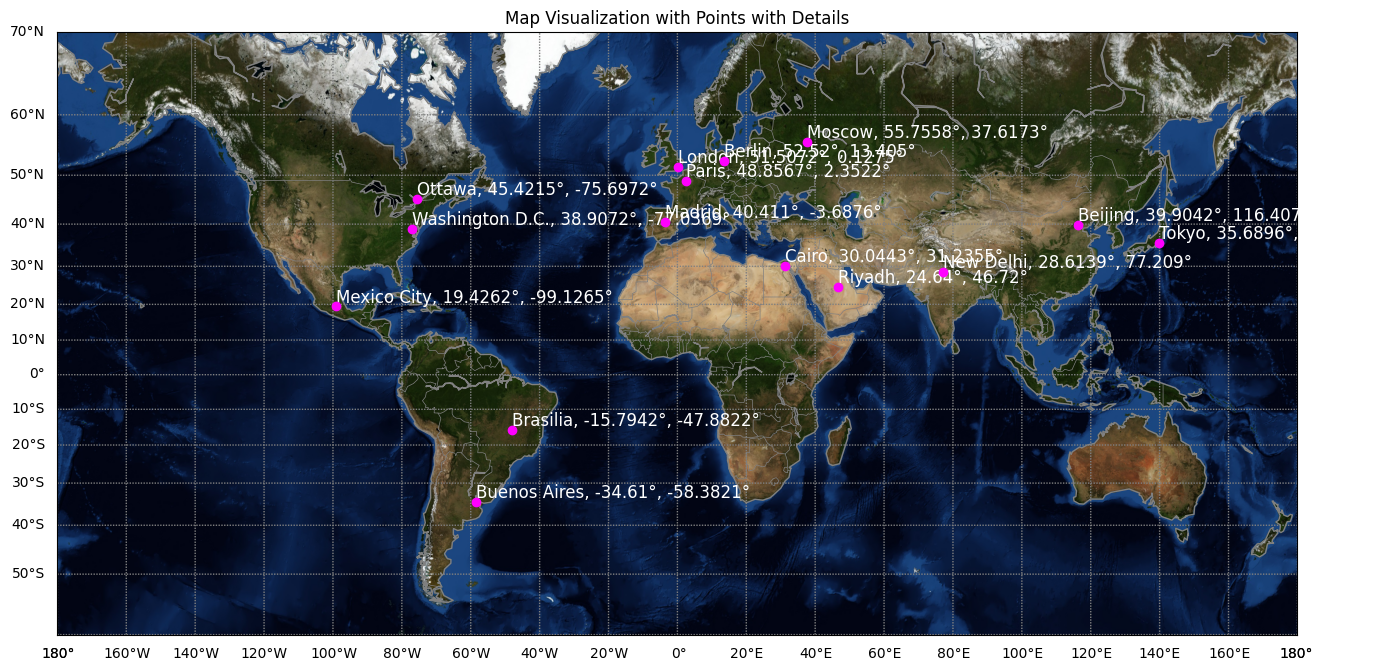

In [543]:
# Visualizing points with some details on map
visualize_points(points_with_names)

## Perimeter Calculation

In [544]:
# Calculating the perimeter of a figure (convex hull)
calculate_perimeter(points_without_names)

44025.894117492775

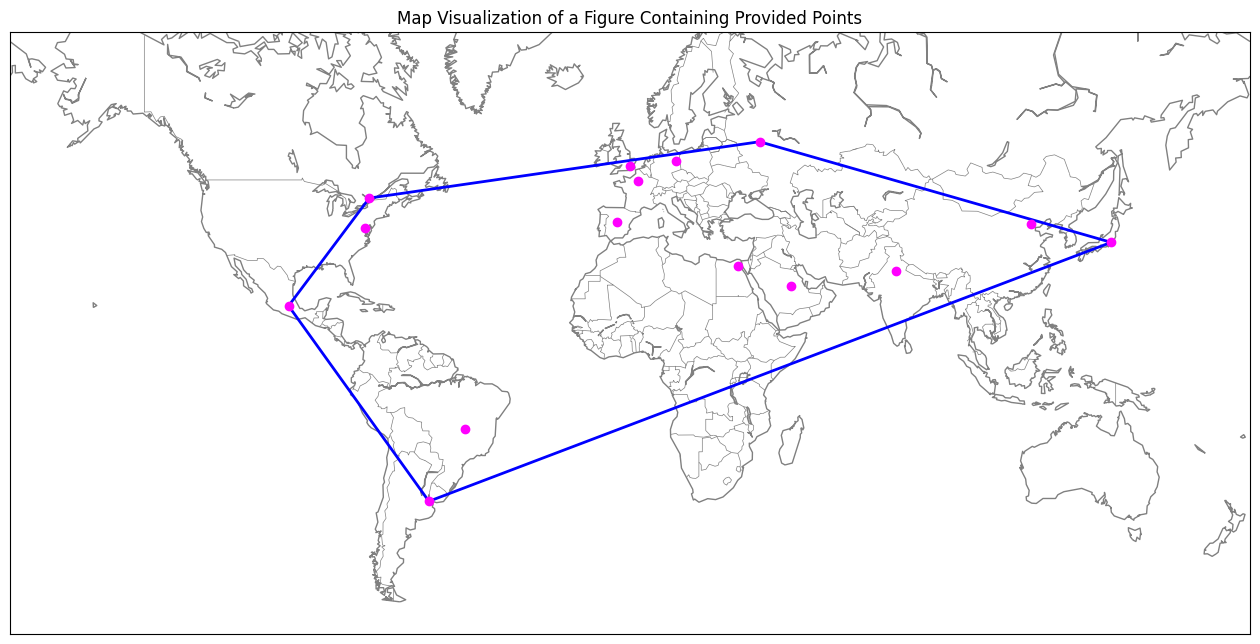

In [545]:
# Visualizing figure that includes all points
visualize_figure(points_without_names)